<a href="https://colab.research.google.com/github/ashwinijadi123/Basic-python-programs/blob/main/Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets evaluate torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 948.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
!pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 43.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.4
    Uninstalling huggingface-hub-0.33.4:
      Successfully uninstalled huggingface-hub-0.33.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.8 MB/s eta 0:00:00


In [ ]:
# ===============================================
# 1. Import Required Libraries
# ===============================================
import os
import torch
from transformers import BertTokenizerFast, BertForQuestionAnswering, Trainer, TrainingArguments
from datasets import load_dataset
import evaluate
import numpy as np

# Disable WandB logging
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ===============================================
# 2. Load Dataset and Evaluation Metric
# ===============================================
dataset = load_dataset("squad")
metric = evaluate.load("squad")

In [ ]:
# ===============================================
# 3. Load Tokenizer and Model
# ===============================================
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForQuestionAnswering.from_pretrained(model_name).to(device)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ===============================================
# 4. Preprocessing Function
# ===============================================
def add_token_positions(example):
    tokenized_example = tokenizer(
        example["question"],
        example["context"],
        truncation=True,
        padding="max_length",
        max_length=384,
        return_offsets_mapping=True
    )

    offsets = tokenized_example.pop("offset_mapping")
    answer = example["answers"]["text"][0]
    start_char = example["answers"]["answer_start"][0]
    end_char = start_char + len(answer)

    start_token = end_token = 0
    for idx, (start, end) in enumerate(offsets):
        if start <= start_char < end:
            start_token = idx
        if start < end_char <= end:
            end_token = idx
            break

    tokenized_example["start_positions"] = start_token
    tokenized_example["end_positions"] = end_token
    return tokenized_example

In [ ]:
# ===============================================
# 5. Process and Reduce Dataset to 625 Samples
# ===============================================
train_dataset = dataset["train"].map(add_token_positions, batched=False)
valid_dataset = dataset["validation"].map(add_token_positions, batched=False)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "start_positions", "end_positions"])
valid_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "start_positions", "end_positions"])

# Reduce to 625 samples each
train_dataset = train_dataset.shuffle(seed=42).select(range(5000))
valid_dataset = valid_dataset.shuffle(seed=42).select(range(1000))

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
# ===============================================
# 6. Compute Metrics (F1 & Exact Match)
# ===============================================
def compute_metrics_builder(dataset):
    def compute_metrics(pred):
        start_logits, end_logits = pred.predictions
        start_preds = np.argmax(start_logits, axis=1)
        end_preds = np.argmax(end_logits, axis=1)

        predictions = []
        references = []

        for i in range(min(len(dataset), len(start_preds))):
            input_ids = dataset[i]["input_ids"]
            pred_ans_ids = input_ids[start_preds[i]:end_preds[i]+1]
            pred_ans = tokenizer.decode(pred_ans_ids, skip_special_tokens=True)

            gt_start = dataset[i]["start_positions"]
            gt_end = dataset[i]["end_positions"]
            gt_ans_ids = input_ids[gt_start:gt_end+1]
            gt_ans = tokenizer.decode(gt_ans_ids, skip_special_tokens=True)

            predictions.append({"id": str(i), "prediction_text": pred_ans})
            references.append({"id": str(i), "answers": {"text": [gt_ans], "answer_start": [0]}})

        return metric.compute(predictions=predictions, references=references)
    return compute_metrics

In [ ]:
# ===============================================
# 7. Training Arguments (Compatible Version)
# ===============================================

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=500,
    save_total_limit=1,
    fp16=True  # if GPU with mixed precision support
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:

# ===============================================
# 8. Trainer Setup
# ===============================================
# Define a new trainer for training evaluation
train_eval_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,  # same as train set
    compute_metrics=compute_metrics_builder(train_dataset)
)


In [ ]:
# ===============================================
# 9. Train the Model
# ===============================================
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
500,0.032100
1000,0.033100
1500,0.029500


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=1875, training_loss=0.04533593393961589, metrics={'train_runtime': 425.7097, 'train_samples_per_second': 35.235, 'train_steps_per_second': 4.404, 'total_flos': 2939588513280000.0, 'train_loss': 0.04533593393961589, 'epoch': 3.0})

In [ ]:
# Assign the metrics function to the trainer
trainer.compute_metrics = compute_metrics_builder(valid_dataset)

# Evaluate on validation set
val_metrics = trainer.evaluate(eval_dataset=valid_dataset)

# Print the results
print("📊 Validation Metrics:", val_metrics)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📊 Validation Metrics: {'eval_loss': 5.369917869567871, 'eval_exact_match': 37.8, 'eval_f1': 53.58257837819834, 'eval_runtime': 7.8349, 'eval_samples_per_second': 127.634, 'eval_steps_per_second': 15.954, 'epoch': 3.0}


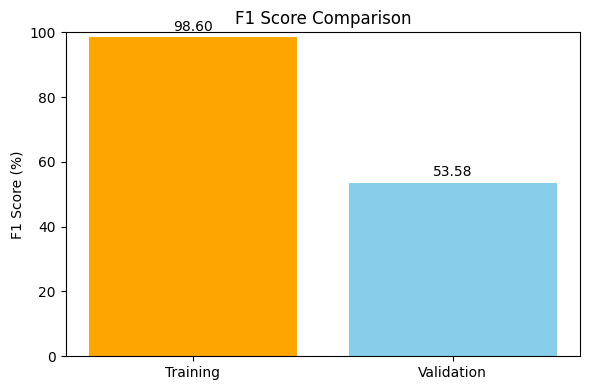

In [ ]:
import matplotlib.pyplot as plt

# Replace with your actual F1 scores
train_f1 = train_eval["eval_f1"]
val_f1 = trainer.evaluate()["eval_f1"]

labels = ["Training", "Validation"]
f1_scores = [train_f1, val_f1]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, f1_scores, color=["orange", "skyblue"])
plt.ylim(0, 100)
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score (%)")

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f"{yval:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()



In [ ]:
from transformers import pipeline

# 1. Load QA pipeline with your fine-tuned model and tokenizer
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

# 2. Define your question and context
question = "Where is the Eiffel Tower located?"
context = "The Eiffel Tower is located in Paris, France. It was built in 1889 and is one of the most famous landmarks in the world."

# 3. Run inference
result = qa_pipeline({
    "question": question,
    "context": context
})

# 4. Print result
print("\n Predicted Answer:", result['answer'])
print(" Confidence Score:", round(result['score'] * 100, 2), "%")



Device set to use cuda:0



 Predicted Answer: Paris, France. It was built in 1889 and is one of the most
 Confidence Score: 0.19 %
